In [81]:
import uproot
import matplotlib.pyplot as plt 
import mplhep as hep
import numpy as np
import fnmatch
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from tqdm import tqdm
import hist
import pickle as pkl
import pandas as pd
import glob as glob

In [191]:
idx_u0 = 0 
idx_v0 = 1984
idx_w0 = 3968
idx_u1 = 5632
idx_v1 = 7616
idx_w1 = 9000

def find_u0_ch(ch_num):
    if (((ch_num >= 0 ) & (ch_num < idx_v0))):
        return True
    else:
        return False

def find_v0_ch(ch_num):
    if (((ch_num >= idx_v0 ) & (ch_num < idx_w0))):
        return True
    else:
        return False
    
def find_w0_ch(ch_num):
    if (((ch_num >= idx_w0 ) & (ch_num < idx_u1))):
        return True
    else:
        return False
    
def find_u1_ch(ch_num):
    if (((ch_num >=  idx_u1 ) & (ch_num < idx_v1))):
        return True
    else:
        return False

def find_v1_ch(ch_num):
    if (((ch_num >= idx_v1 ) & (ch_num < idx_w1))):
        return True
    else:
        return False
    
def find_w1_ch(ch_num):
    if (((ch_num >= idx_w1 ))):
        return True
    else:
        return False
    
def u0_ch(input): 
    tpc0_arr = input[0     :idx_v0]
    return tpc0_arr

def v0_ch(input): 
    tpc0_arr = input[idx_v0:idx_w0]
    return tpc0_arr

def w0_ch(input): 
    tpc0_arr = input[idx_w0:idx_u1]
    return tpc0_arr

def u1_ch(input): 
    tpc1_arr = input[idx_u1:idx_v1]
    return tpc1_arr

def v1_ch(input): 
    tpc1_arr = input[idx_v1:idx_w1]
    return tpc1_arr

def w1_ch(input): 
    tpc1_arr = input[idx_w1:]
    return tpc1_arr

def caf_split_tpc(df):
    tpc0 = df[df["rec.mc.nu.prim.start.x"] < 0]
    tpc1 = df[df["rec.mc.nu.prim.start.x"] > 0]
    return tpc0, tpc1

def find_nonzero_ch(wvfm):
    # peak threshold = 800
    mask = (wvfm > 800).sum(axis = 1)
    return np.where(mask>0)[0]
    
def quartile_reso(data):
    data = np.round(np.sort(data),3)
    median = np.median(data)
    median_idx = int(np.round(len(data)/2))
    quar_size =  int(np.round(len(data)*0.5*0.683))
    Q1 = data[median_idx - quar_size]
    Q3 = data[median_idx + quar_size]
    quartile_reso = np.sqrt(0.5*(median-Q1)**2 + 0.5*(median-Q3)**2)
    return quartile_reso

In [2]:
with open("proton_caf.list") as f:
    caf_list = f.read().split('\n')

with open("proton_wvfm.list") as f:
    wvfm_list = f.read().split('\n')

In [208]:
u_sim_arr = np.array([]); u_dec_arr = np.array([]); u_diff_arr = np.array([]); u_theta_arr = np.array([]); u_depE_arr = np.array([])
v_sim_arr = np.array([]); v_dec_arr = np.array([]); v_diff_arr = np.array([]); v_theta_arr = np.array([]); v_depE_arr = np.array([])
w_sim_arr = np.array([]); w_dec_arr = np.array([]); w_diff_arr = np.array([]); w_theta_arr = np.array([]); w_depE_arr = np.array([])

nfiles = 10

for i in tqdm(range(nfiles)):
    wvfm = uproot.open(wvfm_list[i])
    dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
    sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')

    # caf = uproot.open("/pnfs/sbnd/scratch/users/lynnt/v09_75_03_02/electron_gun/electron_caf/3414904_0/prodsingle_sbnd_SinglesGen-20230812T042829_G4-20230812T043429_WCLS-20230812T050513_405fd978-8f82-4ce9-9dc6-70c89057648f.flat.caf.root:recTree")
    caf = uproot.open(caf_list[i]+":recTree")
    tree = caf.arrays(["rec.hdr.run",
                            "rec.hdr.subrun",
                            "rec.hdr.evt",    
                            "rec.mc.nu.prim.startp.x" ,
                            "rec.mc.nu.prim.startp.y",
                            "rec.mc.nu.prim.startp.z",
                            "rec.mc.nu.prim.startE",
                            "rec.mc.nu.prim.endE"],library='pd')

    tree["theta_xz"] = np.arctan(abs(tree["rec.mc.nu.prim.startp.x"]/tree["rec.mc.nu.prim.startp.z"]))*(180/np.pi)
    tree["depE"] =  tree["rec.mc.nu.prim.startE"] - tree["rec.mc.nu.prim.endE"]
    
    for event in range(len(dec_names)):
        evt_sim = wvfm[sim_names[event]].values()
        evt_dec = wvfm[dec_names[event]].values()*50
        nonZeroCh = find_nonzero_ch(evt_sim)
        
        theta0= tree.iloc[2*event+1]["theta_xz"]
        theta1= tree.iloc[2*event]["theta_xz"]
        depE0= tree.iloc[2*event+1]["depE"]
        depE1= tree.iloc[2*event]["depE"]
        
        for idx, j in enumerate(nonZeroCh):
            proton_wvfm_dec = wvfm[dec_names[event]].values()[j]*50 # have to re-add the scaling factor
            proton_wvfm_sim = wvfm[sim_names[event]].values()[j]
            # # sim_out = find_peaks(proton_wvfm_sim,height=15,threshold=0,prominence=0,width=5)
            # sim_out = find_peaks(proton_wvfm_sim,height=10,threshold=0,prominence=0,width=0)
            # right_side = 0
            # left_side = 3400
            # for peak in range(len(sim_out[0])):
            #         if sim_out[1]["right_bases"][peak] > right_side:
            #             right_side = sim_out[1]["right_bases"][peak]
            #         if sim_out[1]["left_bases"][peak] < left_side:
            #             left_side = sim_out[1]["left_bases"][peak]
            if ((find_u0_ch(j)) | (find_u1_ch(j))):
                u_sim_arr = np.append(u_sim_arr,np.sum(proton_wvfm_sim))
                u_dec_arr = np.append(u_dec_arr,np.sum(proton_wvfm_dec))
                if (find_u0_ch(j)):
                    u_theta_arr = np.append(u_theta_arr,theta0)
                    u_depE_arr = np.append(u_depE_arr,depE0)
                elif (find_u1_ch(j)):
                    u_theta_arr = np.append(u_theta_arr,theta1)
                    u_depE_arr = np.append(u_depE_arr,depE1)
            if ((find_v0_ch(j)) | (find_v1_ch(j))):
                v_sim_arr = np.append(v_sim_arr,np.sum(proton_wvfm_sim))
                v_dec_arr = np.append(v_dec_arr,np.sum(proton_wvfm_dec))
                if (find_v0_ch(j)):
                    v_theta_arr = np.append(v_theta_arr,theta0)
                    v_depE_arr = np.append(v_depE_arr,depE0)
                elif (find_v1_ch(j)):
                    v_theta_arr = np.append(v_theta_arr,theta1)
                    v_depE_arr = np.append(v_depE_arr,depE1)
            if ((find_w0_ch(j)) | (find_w1_ch(j))):
                w_sim_arr = np.append(w_sim_arr,np.sum(proton_wvfm_sim))
                w_dec_arr = np.append(w_dec_arr,np.sum(proton_wvfm_dec))
                if (find_w0_ch(j)):
                    w_theta_arr = np.append(w_theta_arr,theta0)
                    w_depE_arr = np.append(w_depE_arr,depE0)
                elif (find_w1_ch(j)):
                    w_theta_arr = np.append(w_theta_arr,theta1)
                    w_depE_arr = np.append(w_depE_arr,depE1)
    u_diff_arr = (u_dec_arr - u_sim_arr)/u_sim_arr
    v_diff_arr = (v_dec_arr - v_sim_arr)/v_sim_arr
    w_diff_arr = (w_dec_arr - w_sim_arr)/w_sim_arr
    
    # np.savez("npz_files/u_plane/u_subrun_"+str(int(subrun))+".npz",u_sim_arr=u_sim_arr,u_dec_arr=u_dec_arr,u_diff_arr=u_diff_arr,u_theta_arr=u_theta_arr,u_depE_arr=u_depE_arr,)
    # np.savez("npz_files/v_plane/v_subrun_"+str(int(subrun))+".npz",v_sim_arr=v_sim_arr,v_dec_arr=v_dec_arr,v_diff_arr=v_diff_arr,v_theta_arr=v_theta_arr,v_depE_arr=v_depE_arr,)
    # np.savez("npz_files/w_plane/w_subrun_"+str(int(subrun))+".npz",w_sim_arr=w_sim_arr,w_dec_arr=w_dec_arr,w_diff_arr=w_diff_arr,w_theta_arr=w_theta_arr,w_depE_arr=w_depE_arr,)
    # # clear arrays
    # u_sim_arr = np.array([]); u_dec_arr = np.array([]); u_diff_arr = np.array([]); u_theta_arr = np.array([]); u_depE_arr = np.array([])
    # v_sim_arr = np.array([]); v_dec_arr = np.array([]); v_diff_arr = np.array([]); v_theta_arr = np.array([]); v_depE_arr = np.array([])
    # w_sim_arr = np.array([]); w_dec_arr = np.array([]); w_diff_arr = np.array([]); w_theta_arr = np.array([]); w_depE_arr = np.array([])

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [07:14<00:00, 43.47s/it]


In [243]:
# get files in directory using glob
u_files = glob.glob('npz_files/u_plane/*')
v_files = glob.glob('npz_files/v_plane/*')
w_files = glob.glob('npz_files/w_plane/*')

u_sim_arr = np.array([]); u_dec_arr = np.array([]); u_diff_arr = np.array([]); u_theta_arr = np.array([]); u_depE_arr = np.array([])
v_sim_arr = np.array([]); v_dec_arr = np.array([]); v_diff_arr = np.array([]); v_theta_arr = np.array([]); v_depE_arr = np.array([])
w_sim_arr = np.array([]); w_dec_arr = np.array([]); w_diff_arr = np.array([]); w_theta_arr = np.array([]); w_depE_arr = np.array([])
    
for i in range(len(u_files)):
    u_sim_arr = np.append(u_sim_arr, np.load(u_files[i])["u_sim_arr"])
    u_dec_arr = np.append(u_dec_arr, np.load(u_files[i])["u_dec_arr"])
    u_diff_arr = np.append(u_diff_arr, np.load(u_files[i])["u_diff_arr"])
    u_theta_arr = np.append(u_theta_arr, np.load(u_files[i])["u_theta_arr"])
    u_depE_arr = np.append(u_depE_arr, np.load(u_files[i])["u_depE_arr"])

    v_sim_arr = np.append(v_sim_arr, np.load(v_files[i])["v_sim_arr"])
    v_dec_arr = np.append(v_dec_arr, np.load(v_files[i])["v_dec_arr"])
    v_diff_arr = np.append(v_diff_arr, np.load(v_files[i])["v_diff_arr"])
    v_theta_arr = np.append(v_theta_arr, np.load(v_files[i])["v_theta_arr"])
    v_depE_arr = np.append(v_depE_arr, np.load(v_files[i])["v_depE_arr"])

    w_sim_arr = np.append(w_sim_arr, np.load(w_files[i])["w_sim_arr"])
    w_dec_arr = np.append(w_dec_arr, np.load(w_files[i])["w_dec_arr"])
    w_diff_arr = np.append(w_diff_arr, np.load(w_files[i])["w_diff_arr"])
    w_theta_arr = np.append(w_theta_arr, np.load(w_files[i])["w_theta_arr"])
    w_depE_arr = np.append(w_depE_arr, np.load(w_files[i])["w_depE_arr"])

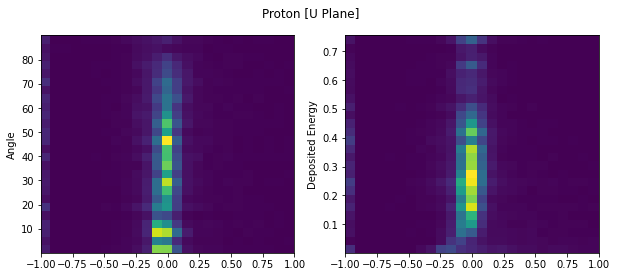

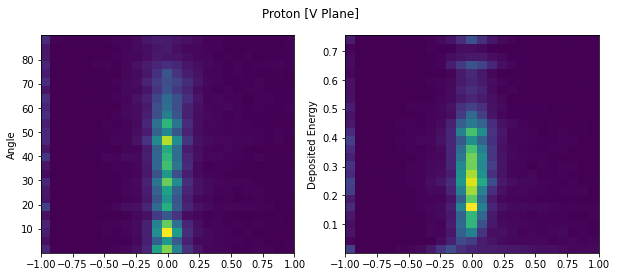

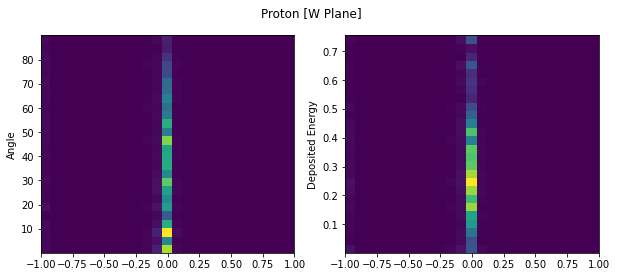

In [244]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist2d(u_diff_arr,u_theta_arr,bins=[np.linspace(-1,1,26),26])
axes[1].hist2d(u_diff_arr,u_depE_arr, bins=[np.linspace(-1,1,26),26])
axes[0].set_ylabel("Angle")
axes[1].set_ylabel("Deposited Energy")
plt.suptitle("Proton [U Plane]")
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist2d(v_diff_arr,v_theta_arr,bins=[np.linspace(-1,1,26),26])
axes[1].hist2d(v_diff_arr,v_depE_arr, bins=[np.linspace(-1,1,26),26])
axes[0].set_ylabel("Angle")
axes[1].set_ylabel("Deposited Energy")
plt.suptitle("Proton [V Plane]")
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist2d(w_diff_arr,w_theta_arr,bins=[np.linspace(-1,1,26),26])
axes[1].hist2d(w_diff_arr,w_depE_arr, bins=[np.linspace(-1,1,26),26])
axes[0].set_ylabel("Angle")
axes[1].set_ylabel("Deposited Energy")
plt.suptitle("Proton [W Plane]")
plt.show()

In [245]:
ticks= [0,5,10,20,30,40,50,60,70,80,85]
ticks_prime = np.zeros(len(ticks))
for i, tick in enumerate(ticks):
    ticks_prime[i] = np.round(np.arctan(np.tan(tick*np.pi/180)/np.cos(60*np.pi/180))*180/np.pi)

In [246]:
u_mean = np.zeros(10); u_stdd = np.zeros(10); u_efff = np.zeros(10)
v_mean = np.zeros(10); v_stdd = np.zeros(10); v_efff = np.zeros(10)
w_mean = np.zeros(10); w_stdd = np.zeros(10); w_efff = np.zeros(10)

for i in range(len(ticks)-1):
    lower = ticks[i]
    upper = ticks[i+1]
    u_mask = np.where((u_theta_arr < upper) & (u_theta_arr >= lower),True,False)
    v_mask = np.where((v_theta_arr < upper) & (v_theta_arr >= lower),True,False)
    w_mask = np.where((w_theta_arr < upper) & (w_theta_arr >= lower),True,False)
    
    u_fail = np.where(((u_dec_arr/u_sim_arr) < 0.1) | ((u_dec_arr-u_sim_arr)/u_sim_arr > 2),True,False)
    v_fail = np.where(((v_dec_arr/v_sim_arr) < 0.1) | ((v_dec_arr-v_sim_arr)/v_sim_arr > 2),True,False)
    w_fail = np.where(((w_dec_arr/w_sim_arr) < 0.1) | ((w_dec_arr-w_sim_arr)/w_sim_arr > 2),True,False)
      
    u_mean[i] = np.median(u_diff_arr[(u_mask) & (u_fail == False)])
    u_stdd[i] = quartile_reso(u_diff_arr[(u_mask) & (u_fail == False)])
    v_mean[i] = np.median(v_diff_arr[(v_mask) & (v_fail == False)])
    v_stdd[i] = quartile_reso(v_diff_arr[(v_mask) & (v_fail == False)])
    w_mean[i] = np.median(w_diff_arr[(w_mask) & (w_fail == False)])
    w_stdd[i] = quartile_reso(w_diff_arr[(w_mask) & (w_fail == False)])
    
    u_efff[i] = np.sum(u_fail[u_mask]) / np.sum(u_mask)
    v_efff[i] = np.sum(v_fail[v_mask]) / np.sum(v_mask)
    w_efff[i] = np.sum(w_fail[w_mask]) / np.sum(w_mask)    

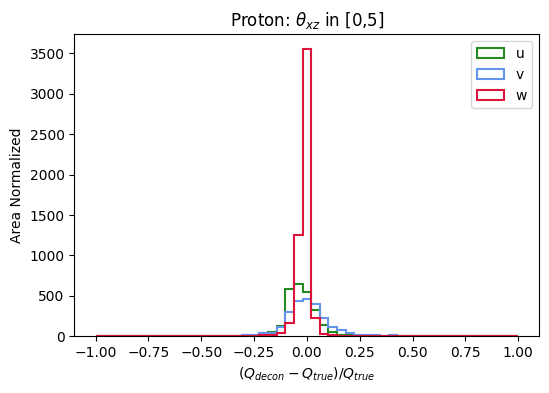

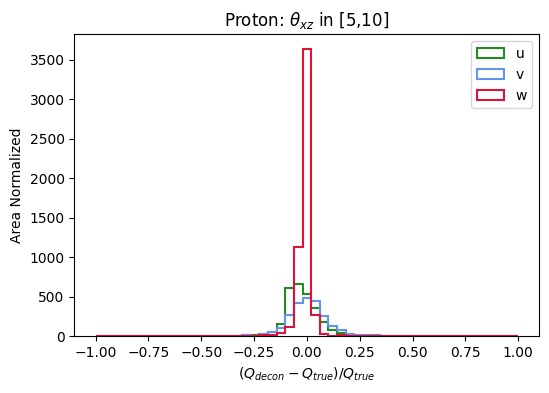

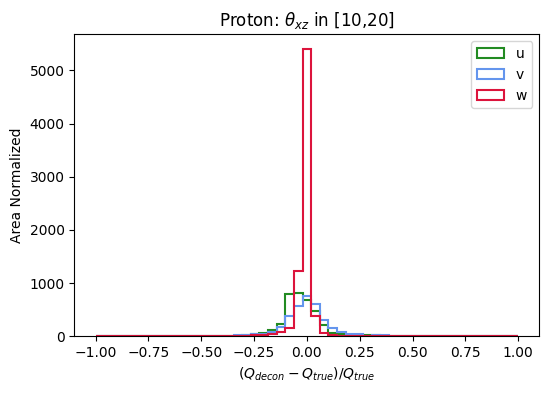

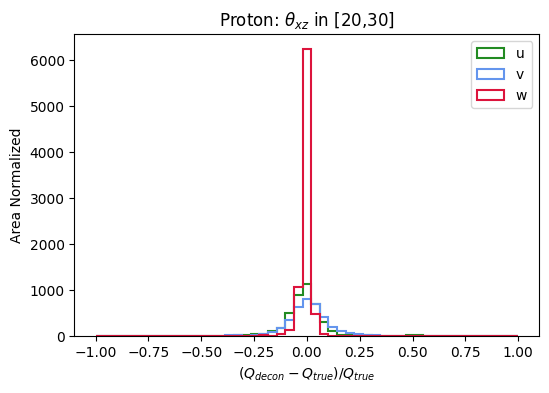

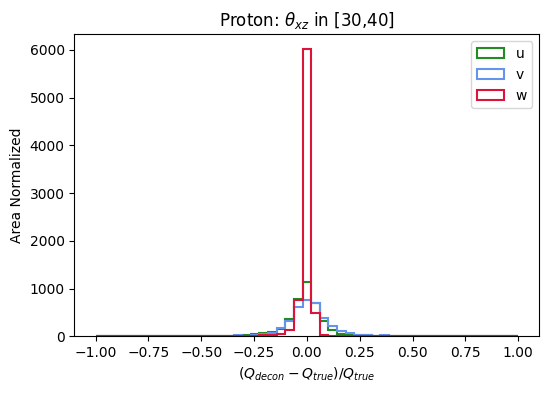

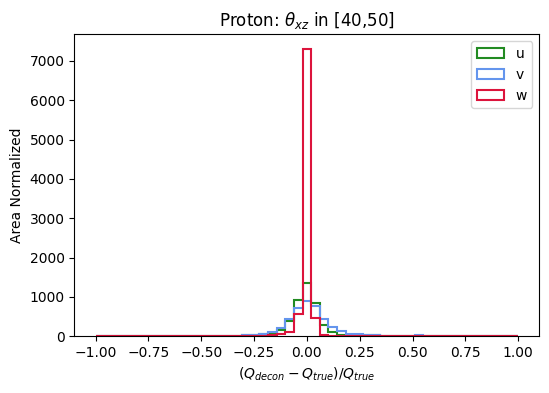

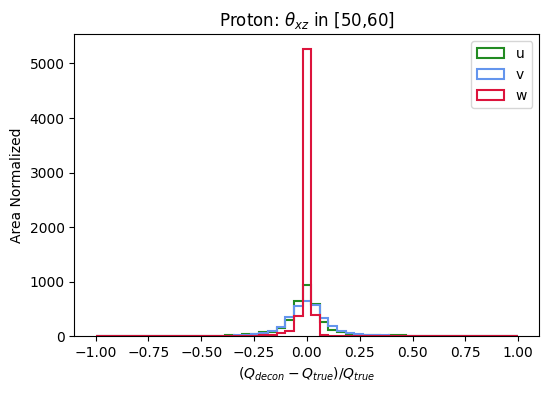

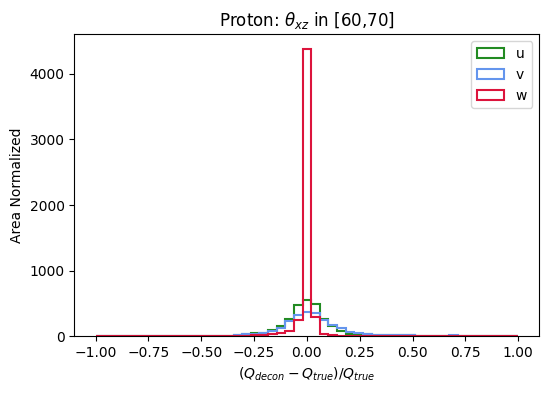

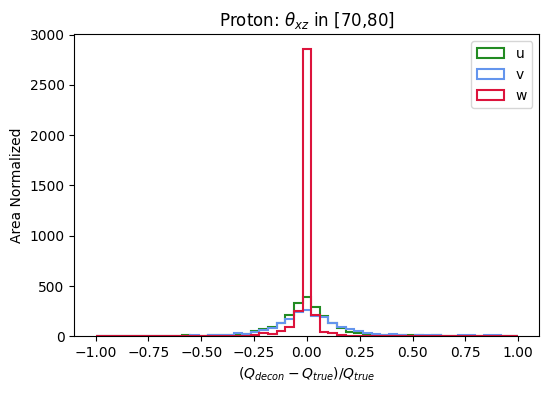

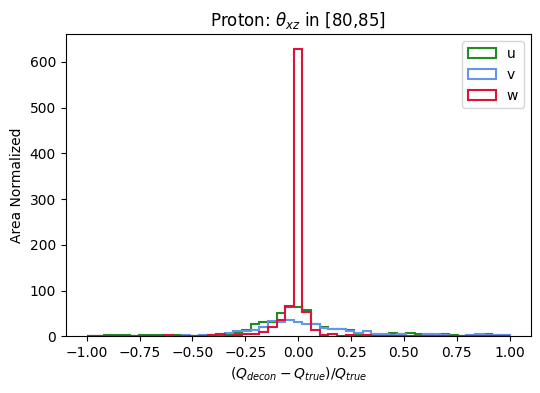

In [255]:
for i in range(len(ticks)-1):
    plt.figure(dpi=100)
    lower = ticks[i]
    upper = ticks[i+1]
    u_mask = np.where((u_theta_arr < upper) & (u_theta_arr >= lower),True,False)
    v_mask = np.where((v_theta_arr < upper) & (v_theta_arr >= lower),True,False)
    w_mask = np.where((w_theta_arr < upper) & (w_theta_arr >= lower),True,False)
    
    u_fail = np.where(((u_dec_arr/u_sim_arr) < 0.1) | ((u_dec_arr-u_sim_arr)/u_sim_arr > 2),True,False)
    v_fail = np.where(((v_dec_arr/v_sim_arr) < 0.1) | ((v_dec_arr-v_sim_arr)/v_sim_arr > 2),True,False)
    w_fail = np.where(((w_dec_arr/w_sim_arr) < 0.1) | ((w_dec_arr-w_sim_arr)/w_sim_arr > 2),True,False)
    plt.hist(u_diff_arr[u_mask & (u_fail==False)],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="u",color="forestgreen")
    plt.hist(v_diff_arr[v_mask & (v_fail==False)],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="v",color="cornflowerblue")
    plt.hist(w_diff_arr[w_mask & (w_fail==False)],bins=np.linspace(-1,1,50),lw=1.5,histtype="step",label="w",color="crimson")
    plt.legend()
    plt.ylabel("Area Normalized")
    plt.xlabel(r"$(Q_{decon} - Q_{true}) / Q_{true}$")
    plt.title(fr"Proton: $\theta_{{xz}}$ in [{lower},{upper}]")
    # plt.yscale("log")
    plt.show()

In [250]:
ticklabels = []
for i, angle in enumerate(ticks):
    ticklabels.append(str(int(angle)) + "(" + str(int(ticks_prime[i])) + ")")

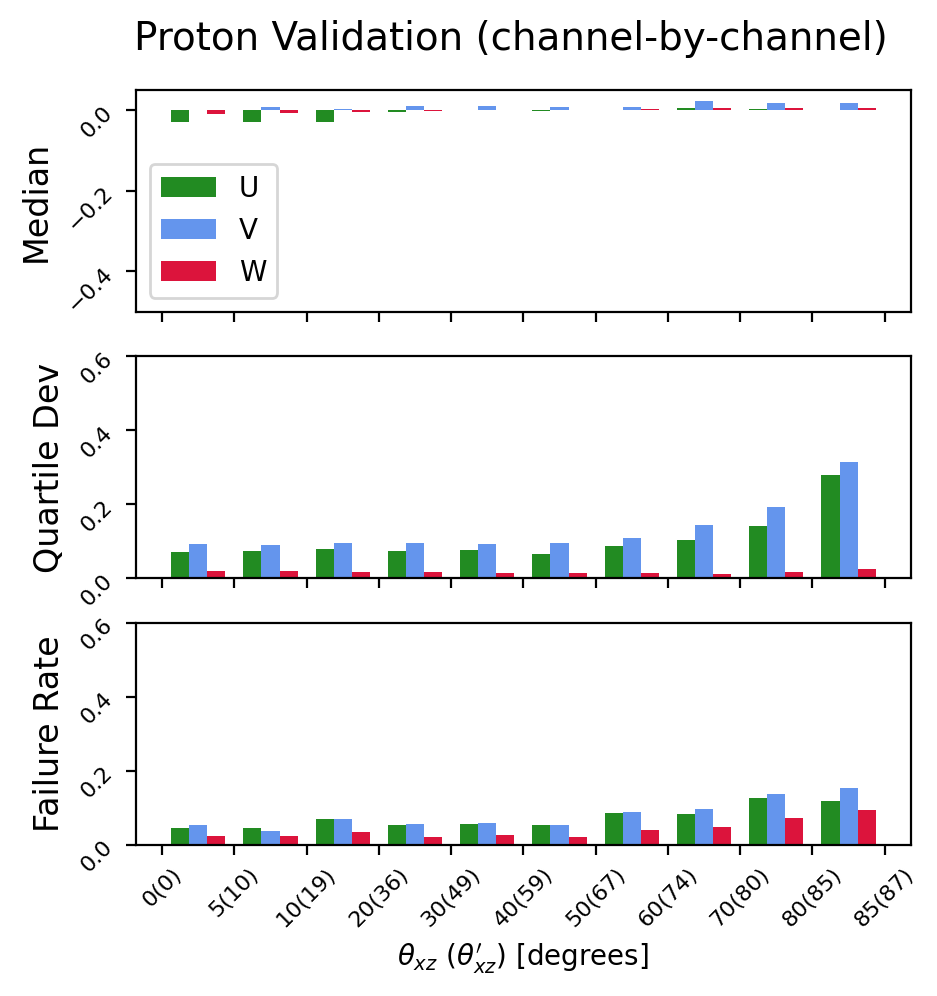

In [254]:
fig, axes = plt.subplots(3,1,figsize=(5,5),sharex=True,dpi=200)
# plt.subplots_adjust(hspace=0.08)
N=10
width = 0.25
# ticklabels = ["0","5","10","20","30","40","50","60","70","80","85"]
axes[0].set_xticks(np.arange(N+1)-0.5)
axes[0].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[0].bar(np.arange(N)-width, u_mean,width=width,label="U",color="forestgreen")
axes[0].bar(np.arange(N)      , v_mean,width=width,label="V",color="cornflowerblue")
axes[0].bar(np.arange(N)+width, w_mean,width=width,label="W",color="crimson")
axes[0].set_ylabel("Median",fontsize=12)
axes[0].legend()
axes[0].set_ylim(-0.50,0.05)

axes[1].bar(np.arange(N)-width,u_stdd,width=width,label="U",color="forestgreen")
axes[1].bar(np.arange(N),      v_stdd,width=width,label="V",color="cornflowerblue")
axes[1].bar(np.arange(N)+width,w_stdd,width=width,label="W",color="crimson")
axes[1].set_ylabel("Quartile Dev",fontsize=12)
axes[1].tick_params(labelbottom=False)
axes[1].set_yticks([0.0,0.2,0.4,0.6])
axes[1].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[1].set_ylim(0,0.6)

axes[2].bar(np.arange(N)-width,u_efff,width=width,label="U",color="forestgreen")
axes[2].bar(np.arange(N),      v_efff,width=width,label="V",color="cornflowerblue")
axes[2].bar(np.arange(N)+width,w_efff,width=width,label="W",color="crimson")
axes[2].set_ylabel("Failure Rate",fontsize=12)
axes[2].tick_params(labelbottom=True)
axes[2].set_yticks([0.0,0.2,0.4,0.6])
axes[2].yaxis.set_tick_params(labelsize=8,rotation=45)
axes[2].set_xticklabels(ticklabels)
axes[2].xaxis.set_tick_params(labelsize=8,rotation=45)
axes[2].set_xlabel(r"$\theta_{xz}$ ($\theta_{xz}'$) [degrees]")
axes[2].set_ylim(0,0.6)

plt.suptitle("Proton Validation (channel-by-channel)",fontsize=14,y=0.95)
plt.show()